# Practical Measurement of Fairness in Classifcation Tasks for Healthcare
----

## About
This is an archived, polished version of the notebook presented in conjunction with the [KDD 2020 Tutorial on Fairness in Machine Learning for Healthcare](../publications/KDD2020-FairnessInHealthcareML-Slides.pptx). For an updated tutorial on fairness measurement, please see the [Measuring Fairness in Binary Classification Tutorial](../fairMLHealth/tutorials_and_examples/Tutorial-MeasuringFairnessInBinaryClassification.ipynb). For additional information, please see our [tutorials_and_examples section](../fairMLHealth/tutorials_and_examples).

## Overview

This tutorial introduces concepts, methods, and libraries for measuring fairness in machine learning models as it relates to problems in healthcare. Through the this noebook you will first learn basic background about fairness metrics", before generating a simple baseline model predicting Length of Stay (LOS) using data from the [MIMIC-III clinical database](https://mimic.physionet.org/gettingstarted/access/). This baseline model will be used as an example to understand common measures like *Disparate Impact Ratios* and *Consistency Scores*. Through this notebook you will gain a familiarity with the Scikit-Learn-compatible tools available in [AIF360](http://aif360.mybluemix.net/) and [FairLearn](https://fairlearn.github.io/), two of the most comprehensive and flexible Python libraries for measuring and addressing bias in machine learning models.

## Tutorial Contents
[Part 0](#part0) - Metrics of Fairness

[Part 1](#part1) - Model Setup

[Part 2](#part2) - Measuring Fairness with AIF360

[Part 3](#part3) - Comparing Two Models

[Part 4](#part4) - Testing Other Protected Attributes

[Part 5](#part5) - Comparing AIF360 and FairLearn

## Tutorial Requirements

To run this notebook, please install FairMLHealth using [the instructions posted in GitHub](https://github.com/KenSciResearch/fairMLHealth).

The tutorial also uses data from the MIMIC III Critical Care database, a freely accessible source of electronic health records from Beth Israel Deaconess Medical Center in Boston. To download the MIMIC III data, please use this link: [Access to MIMIC III](https://mimic.physionet.org/gettingstarted/access/). Please save the data with the default directory name ("MIMIC"). No further action is required beyond remembering the download location: you do not need to unzip any files.

Please note that a basic knowledge of machine learning implementation in Python is assumed. 


----
# Part 0 - Metrics of Fairness <a class = "anchor" id = "part0"></a>
*Brief context for the evaluation of fairness in machine learning. For more information, see the [KDD 2020 Tutorial on Fairness in Machine Learning for Healthcare](../publications/KDD2020-FairnessInHealthcareML-Slides.pptx).*

## "Fair" Models
In issues of social justice, discrimination is the unjustified, differential treatment of individuals based on their sociodemographic status. [[Romei and Ruggieri (2014)]](#romei2014_ref)  A "fair" model, in this case, is one that does not discriminate.

The "socially salient" sociodemographic groups ([[Speicher 2018]](#speicher2018_ref)) about which discrimination is measured are known as ***protected attributes***, also known as *sensitive attributes* or *protected features*. 

There are six common metrics for determining whether a machine learning model is considered "fair": Equal Treatment ("Unawareness"), Demographic Parity, Equalized Odds, Predictive Parity, Individual Fairness, and Counterfactual Fairness. Basic definitions for each of these metrics are provided for you in the [Quick Reference](#metric_quickref) below. 

## Measuring Fairness  <a id = "disparateimpact"></a>

The term "discrimination" typically evokes direct or deliberate action to disadvantage one race, religion, or ethnicity. This kind of disparity is known as *disparate treatment*. However, more insidious form of discrimination can occur when ostensibly unbiased practices result in the – perhaps unconscious – unfair treatment of a socially disadvantaged group. This is known as *disparate impact*. 

Disparate impact in a machine learning model comes bias in at least one of two sources: the data or the algorithm. A popular example is the prejudicially biased data used for recidivism prediction. Due to disparate socioeconomic factors and systemic racism in the United States, blacks have historically been (and are still) incarcerated at higher rates than whites.[[NAACP]](#naacp)  Not coincidentally, blacks are also exonerated due wrongful accusation at a considerably higher rate than whites. [[NAACP]](#naacp)  A recidivism model that fails to adjust for circumstances such as these will predict a higher rate of recidivism among blacks. 

Machine learning models can also be a source of disparate impact in their implementation, through unconscious human biases that affect the fair interpretation or use of the model's results. This tutorial does not cover measurement of fairness at implementation. However, if you are interested in fair implementationimplementation, we recommend looking at the [Fairness Indicators](https://www.tensorflow.org/tfx/fairness_indicators) suite released by a team at Google.


##  Fairness Metrics Quick Reference <a id = "metric_quickref"></a>
| Metric | Defintion | Weakness | References |
|:------|:------|:------|:------|
|**Unawareness** | A model is unaware if the protected attribute is not used. | Removal of a protected attribute may be ineffectual due to the presence of proxy features highly correlated with the protected attribute.| [Zemel *et al* (2013)](#zemel2013_ref), [Barocas and Selbst (2016)](#barocas2016_ref) |
|**Demographic Parity**| A model has **Demographic Parity** if the predicted positve rates (selection rates) are approximately the same for all protected attribute groups.<br> $$\dfrac{P(\hat{y} = 1 \lvert unprivileged)} {P(\hat{y} = 1 \rvert privileged)}$$ | Historical biases present in the data are not addressed and may still bias the model. | [Zafar *et al* (2017)](#zafar2017_ref) |
|**Equalized Odds**| Odds are equalized if $P(+)$ is approximately the same for all protected attribute groups.<br>  **Equal Opportunity** is a special case of equalized odds specifying that $$P(+ \rvert y = 1)$$ is approximately the same across groups. | Historical biases present in the data  are not addressed and may still bias the model. | [Hardt *et al* (2016)](#hardt2016_ref) |
|**Predictive Parity**| **Predictive Parity** exists where the Positive Predictive Value and Negative Predictive Value are each approximately the same for all protected attribute groups. | Historical biases present in the data are not addressed and may still bias the model.  | [Zafar *et al* (2017)](#zafar2017_ref) |
|**Individual Fairness**| Individual fairness exists if "similar" individuals (ignoring the protected attribute) are likely to have similar predictions. | The appropriate metric for similarity may be ambiguous. |[Dwork (2012)](#dwork2012_ref), [Zemel (2013)](#zemel2013_ref), [Kim *et al* (2018)](#kim2018_ref) |
|**Counterfactual Fairness****| Counterfactual fairness exists where counterfactual replacement of the protected attribute does not significantly alter predictive performance. This counterfactual change must be propogated to correlated variables. | It may be intractable to develop a counterfactual model.  | [Russell *et al* (2017)](#russell2017_ref) |

\** *Note that this tutorial will not elaborate the details of Counterfactual Fairness since the libraries used do not have built-in functionality for it. For an example of Counterfactual Fairness, see "ThemisML" by [Bantilan (2018)](#bantilan2018_ref).*


----
# Part 1 - Model Setup <a class = "anchor" id = "part1"></a>

This section introduces and loads the data subset that will be used in this tutorial. We will use it to generate a simple baseline model that will be used throughout the tutorial.

In [22]:
# Standard Libraries
from IPython.display import Markdown, HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import sys
import warnings

# Load Prediction Libraries
import sklearn.metrics as sk_metric
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Remove limit to the number of columns and column widths displayed by pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0) # adjust column width as needed

# Hide Nearest Neighbors warning rising from AIF360 Consistency Score Measure
warnings.filterwarnings('ignore', category = FutureWarning, 
                        message = "Pass n_neighbors = 5 as keyword args. From version 0.25")


### Below are helper functions that make the tutorial easier to read

In [2]:
# Helpers from local folder
from fairMLHealth.tools import reports, tutorial_helpers as helpers

# Turn on tutorial mode to output simplified versions of comparison reports
helpers.start_tutorial()

# Set ANSI escape sequesnces for text highlighting
bold_on = '\033[1m'
bold_mgta = '\u001b[35m' + bold_on
clr_off = '\033[0m'

def print_color(text, color_helper):
    return(HTML(print(color_helper + text + clr_off)))


## Loading MIMIC III Data

As mentioned above, the MIMIC-III data download contains a folder of zipped_files. The tutorial code in the [Data Subset](#datasubset) section below will automatically unzip and format all necessary data for these experiments, saving the formatted data in the same MIMIC folder. Simply enter the correct path of the MIMIC folder in the following cell to enable this feature. Your path should end with the directory "MIMIC".

Example: path_to_mimic_data_folder = "~/data/MIMIC"

In [3]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

## Data Subset <a id = "datasubset"></a>
Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [4]:
# Load data and subset to ages 65+
df = helpers.load_mimic3_example(path_to_mimic_data_folder) 
df = df.loc[df['AGE'].ge(65), :]
df.drop('GENDER_F', axis = 1, inplace = True) # Redundant with GENDER_M

# Show variable count and feature examples
helpers.print_feature_table(df)
display(Markdown('---'))
display(df.head())


 This data subset has 22434 total observations and 648 input features 



,Raw Feature,Category Count (Encoded Features)
0,AGE,1
1,DIAGNOSIS,282
2,ETHNICITY,41
3,GENDER,1
4,INSURANCE,5
5,LANGUAGE,69
6,MARRIED,7
7,PROCEDURE,222
8,RELIGION,20


---

,ADMIT_ID,AGE,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,ETHNICITY_ASIAN - JAPANESE,ETHNICITY_ASIAN - KOREAN,ETHNICITY_ASIAN - OTHER,ETHNICITY_ASIAN - THAI,ETHNICITY_ASIAN - VIETNAMESE,ETHNICITY_BLACK/AFRICAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_BLACK/CAPE VERDEAN,ETHNICITY_BLACK/HAITIAN,ETHNICITY_CARIBBEAN ISLAND,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER),ETHNICITY_HISPANIC/LATINO - COLOMBIAN,ETHNICITY_HISPANIC/LATINO - CUBAN,ETHNICITY_HISPANIC/LATINO - DOMINICAN,ETHNICITY_HISPANIC/LATINO - GUATEMALAN,ETHNICITY_HISPANIC/LATINO - HONDURAN,ETHNICITY_HISPANIC/LATINO - MEXICAN,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_HISPANIC/LATINO - SALVADORAN,ETHNICITY_MIDDLE EASTERN,ETHNICITY_MULTI RACE ETHNICITY,ETHNICITY_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ETHNICITY_OTHER,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN,LANGUAGE_* BE,LANGUAGE_* FU,LANGUAGE_** T,LANGUAGE_**SH,LANGUAGE_**TO,LANGUAGE_*AMH,LANGUAGE_*ARA,LANGUAGE_*ARM,LANGUAGE_*BEN,LANGUAGE_*BOS,LANGUAGE_*BUL,LANGUAGE_*BUR,LANGUAGE_*CAN,LANGUAGE_*CDI,LANGUAGE_*CHI,LANGUAGE_*DEA,LANGUAGE_*DUT,LANGUAGE_*FAR,LANGUAGE_*FIL,LANGUAGE_*FUL,LANGUAGE_*GUJ,LANGUAGE_*HUN,LANGUAGE_*IBO,LANGUAGE_*KHM,LANGUAGE_*LEB,LANGUAGE_*MAN,LANGUAGE_*MOR,LANGUAGE_*NEP,LANGUAGE_*PER,LANGUAGE_*PHI,LANGUAGE_*PUN,LANGUAGE_*SPA,LANGUAGE_*TAM,LANGUAGE_*TOI,LANGUAGE_*TOY,LANGUAGE_*URD,LANGUAGE_*YID,LANGUAGE_*YOR,LANGUAGE_ALBA,LANGUAGE_AMER,LANGUAGE_ARAB,LANGUAGE_BENG,LANGUAGE_CAMB,LANGUAGE_CANT,LANGUAGE_CAPE,LANGUAGE_ENGL,LANGUAGE_ETHI,LANGUAGE_FREN,LANGUAGE_GREE,LANGUAGE_HAIT,LANGUAGE_HIND,LANGUAGE_ITAL,LANGUAGE_JAPA,LANGUAGE_KORE,LANGUAGE_LAOT,LANGUAGE_MAND,LANGUAGE_PERS,LANGUAGE_POLI,LANGUAGE_PORT,LANGUAGE_PTUN,LANGUAGE_RUSS,LANGUAGE_SERB,LANGUAGE_SOMA,LANGUAGE_SPAN,LANGUAGE_TAGA,LANGUAGE_THAI,LANGUAGE_TURK,LANGUAGE_URDU,LANGUAGE_VIET,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARRIED_DIVORCED,MARRIED_LIFE PARTNER,MARRIED_MARRIED,MARRIED_SEPARATED,MARRIED_SINGLE,MARRIED_UNKNOWN (DEFAULT),MARRIED_WIDOWED,RELIGION_7TH DAY ADVENTIST,RELIGION_BAPTIST,RELIGION_BUDDHIST,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,RELIGION_EPISCOPALIAN,RELIGION_GREEK ORTHODOX,RELIGION_HEBREW,RELIGION_HINDU,RELIGION_JEHOVAH'S WITNESS,RELIGION_JEWISH,RELIGION_LUTHERAN,RELIGION_METHODIST,RELIGION_MUSLIM,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE,DIAGNOSIS_CCS_0,DIAGNOSIS_CCS_1,DIAGNOSIS_CCS_2,DIAGNOSIS_CCS_3,DIAGNOSIS_CCS_4,DIAGNOSIS_CCS_5,DIAGNOSIS_CCS_6,DIAGNOSIS_CCS_7,DIAGNOSIS_CCS_8,DIAGNOSIS_CCS_9,DIAGNOSIS_CCS_10,DIAGNOSIS_CCS_11,DIAGNOSIS_CCS_12,DIAGNOSIS_CCS_13,DIAGNOSIS_CCS_14,DIAGNOSIS_CCS_15,DIAGNOSIS_CCS_16,DIAGNOSIS_CCS_17,DIAGNOSIS_CCS_18,DIAGNOSIS_CCS_19,DIAGNOSIS_CCS_20,DIAGNOSIS_CCS_21,DIAGNOSIS_CCS_22,DIAGNOSIS_CCS_23,DIAGNOSIS_CCS_24,DIAGNOSIS_CCS_25,DIAGNOSIS_CCS_26,DIAGNOSIS_CCS_27,DIAGNOSIS_CCS_28,DIAGNOSIS_CCS_29,DIAGNOSIS_CCS_30,DIAGNOSIS_CCS_31,DIAGNOSIS_CCS_32,DIAGNOSIS_CCS_33,DIAGNOSIS_CCS_34,DIAGNOSIS_CCS_35,DIAGNOSIS_CCS_36,DIAGNOSIS_CCS_37,DIAGNOSIS_CCS_38,DIAGNOSIS_CCS_39,DIAGNOSIS_CCS_40,DIAGNOSIS_CCS_41,DIAGNOSIS_CCS_42,DIAGNOSIS_CCS_43,DIAGNOSIS_CCS_44,DIAGNOSIS_CCS_45,DIAGNOSIS_CCS_46,DIAGNOSIS_CCS_47,DIAGNOSIS_CCS_48,DIAGNOSIS_CCS_49,DIAGNOSIS_CCS_50,DIAGNOSIS_CCS_51,DIAGNOSIS_CCS_52,DIAGNOSIS_CCS_53,DIAGNOSIS_CCS_54,DIAGNOSIS_CCS_55,DIAGNOSIS_CCS_56,DIAGNOSIS_CCS_57,DIAGNOSIS_CCS_58,DIAGNOSIS_CCS_59,DIAGNOSIS_CCS_60,DIAGNOSIS_CCS_61,DIAGNOSIS_CCS_62,DIAGNOS

## Baseline Length of Stay Model
The example models in this tutorial predict the total length of time spent in an ICU ward for a given hospital admission, a.k.a. the "Length of Stay" (LOS). The baseline model will use only the patient's age, their diagnosis, and the use of medical procedures during their stay to predict this value. 

Two target variables will be used in the following experiments: 'length_of_stay' and 'long_los'. The length_of_stay target contains the true value in days for the patient's stay in ICU. The long_los target is a binary variable indicating whether or not the length_of_stay for a given admission is greater than the mean. Observations have been dropped where LOS values are extremely long (30 days or greater) or negative (indicating that the patient was deceased upon arrival at the ICU). We will generate variable below, then generate our baseline model.

---

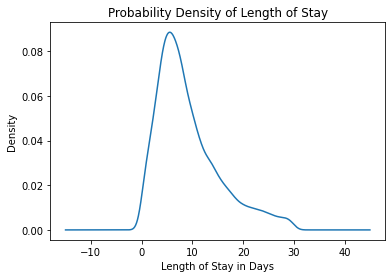

,count,mean,std,min,25%,50%,75%,max
length_of_stay,22434,9.115200,6.208700,0.004200,4.735200,7.579900,12.017700,29.988900
long_los,22434,0.388000,0.487300,0.000000,0.000000,0.000000,1.000000,1.000000


In [5]:

# Display LOS distributions
display(Markdown('---'))
ax = df['length_of_stay'
        ].plot(kind = 'kde', 
               title = "Probability Density of Length of Stay")
ax.set_xlabel("Length of Stay in Days")
plt.show()

# Generate a binary target flagging whether an observation's length_of_stay value is above or below the mean. 
mean_val = df['length_of_stay'].mean()
df['long_los'] = df['length_of_stay'].apply(lambda x: 1 if x > mean_val else 0)
los_tbl = df[['length_of_stay', 'long_los']].describe().transpose().round(4)
los_tbl['count'] = los_tbl['count'].astype(int)
los_tbl = los_tbl.style.applymap(helpers.highlight_col, 
                                 subset = pd.IndexSlice[:, 'mean'], 
                                 color = "aquamarine"
                      ).applymap(helpers.highlight_col, 
                                 subset = pd.IndexSlice[:, 'count'], 
                                 color = "magenta"
                    )
HTML(los_tbl.render())


In [6]:
# Subset and Split Data
X = df.loc[:, [c for c in df.columns 
                if (c.startswith('AGE') 
                or c.startswith('DIAGNOSIS_') 
                or c.startswith('PROCEDURE_'))]]
y = df.loc[:, ['long_los']]

splits = train_test_split(X, y, stratify = y, test_size = 0.33, random_state = 42)
X_train, X_test, y_train, y_test = splits


In [7]:
# Set model parameters (defined here for consistency throughout models)
xgb_params = {'colsample_bytree': 1.0, 'gamma': 2, 
              'learning_rate': 0.05, 'max_depth': 5, 
              'min_child_weight': 1, 'n_estimators': 600, 
              'subsample': 0.6}

# Train Model
baseline_model = XGBClassifier(**xgb_params)
baseline_model.fit(X_train, y_train.iloc[:, 0])
y_pred_baseline = baseline_model.predict(X_test)
y_prob_baseline = baseline_model.predict_proba(X_test)


print("\n", "Prediction Scores for Baseline Model:")
rprt = sk_metric.classification_report(y_test.iloc[:, 0], 
                                       y_pred_baseline,
                                       target_names = ['LOS <= mean', 'LOS > mean'])
rprt = rprt.replace("LOS <= ", bold_mgta+ "LOS <= "
          ).replace("LOS >", clr_off + "LOS >")
HTML(print(rprt))


 Prediction Scores for Baseline Model:
              precision    recall  f1-score   support

 LOS <= mean       0.79      0.88      0.83      4531
  LOS > mean       0.77      0.63      0.69      2873

    accuracy                           0.78      7404
   macro avg       0.78      0.76      0.76      7404
weighted avg       0.78      0.78      0.78      7404



<IPython.core.display.HTML object>

## Testing Gender as a Protected Attribute
Our first experiment will test the effect of including the protected attribute 'GENDER_M'. This attribute is encoded in our data as a boolean attribute, where 0 = female and 1 = male. Males are assumed to be the privileged group. For the purposes of this experiment no other senstitive attributes or potential proxies will be used, such that only gender, age, diangosis, and procedure codes will be used to make the prediction.

First we will examine fairness measurements for a version of this model that includes gender as a feature, before comparing them to similar measurements for the baseline (without gender). We will see that while some measures can be used to analyze a model in isolation, others (e.g. **Unawareness**) require comparison against other models to clearly demonstrate a model's fairness/unfairness.

---

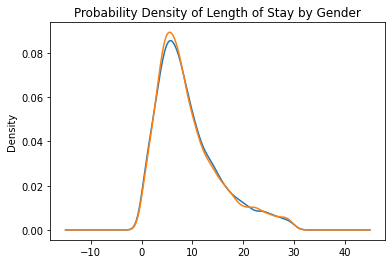

,count,mean,std,min,25%,50%,75%,max
GENDER_M,,,,,,,,
0,9987,9.137300,6.198400,0.004200,4.750700,7.672200,12.066700,29.988900
1,12447,9.097500,6.217100,0.004900,4.714900,7.459700,11.972900,29.966000


In [8]:
# Plot probability density for LOS by gender        
display(Markdown('---'))
ax_g = df.groupby('GENDER_M'
         )['length_of_stay'].plot(kind = 'kde', 
            title = "Probability Density of Length of Stay by Gender")
plt.show()

# Show LOS Distribtuion Relative to GENDER_M
is_male = df['GENDER_M'].eq(1)
g_tbl = df.groupby('GENDER_M')['length_of_stay'].describe().round(4)
g_tbl['count'] = g_tbl['count'].astype(int)
g_tbl = g_tbl.style.applymap(helpers.highlight_col, 
                             subset = pd.IndexSlice[:, 'mean'], 
                             color = "aquamarine"
                  ).applymap(helpers.highlight_col, 
                             subset = pd.IndexSlice[:, 'count'], 
                             color = "magenta"
                  )
HTML(g_tbl.render())

In [9]:
# Update Split Data to Include Gender as a Feature
X_train_gender = X_train.join(df[['GENDER_M']], how = 'inner')
X_test_gender = X_test.join(df[['GENDER_M']], how = 'inner')

# Train New Model with Gender Feature
gender_model = XGBClassifier()
gender_model.fit(X_train_gender, y_train.iloc[:, 0])
y_pred_gender = gender_model.predict(X_test_gender)
y_prob_gender = gender_model.predict_proba(X_test_gender)

print("\n", "Prediction Scores for Model with Gender Included:")
sk_metric.classification_report(y_test.iloc[:, 0], 
                                       y_pred_baseline,
                                       target_names = ['LOS <= mean', 'LOS > mean'])
rprt = rprt.replace("LOS <= ", bold_mgta + "LOS <= "
          ).replace("LOS >", clr_off + "LOS >")
HTML(print(rprt))


 Prediction Scores for Model with Gender Included:
              precision    recall  f1-score   support

 LOS <= mean       0.79      0.88      0.83      4531
  LOS > mean       0.77      0.63      0.69      2873

    accuracy                           0.78      7404
   macro avg       0.78      0.76      0.76      7404
weighted avg       0.78      0.78      0.78      7404



<IPython.core.display.HTML object>

----
# Part 2 - Measuring Fairness with AIF360 <a class = "anchor" id = "part2"></a>
## Getting Started

In [10]:
# Load AIF360 Measures
from aif360.sklearn.metrics import (
    base_rate, selection_rate,
    statistical_parity_difference, disparate_impact_ratio,
    average_odds_difference, average_odds_error, equal_opportunity_difference,
    difference, ratio,
    consistency_score, generalized_entropy_index, theil_index, generalized_entropy_error, between_group_generalized_entropy_error
)


### Statistical Functions of Note
AIF360 has built-in statistical functions that do not measure fairness but may be of use for providing context.

The *Base Rate* returns the average value of the ground truth (optionally weighted). It provides useful context, although it is not technically a measure of fairness. 
> $base\_rate = \sum_{i = 0}^N(y_i)/N$

The *Selection Rate* returns the average predicted value. For a binary prediction problem it equates to the probability of prediction for the positive class ("the probability of selection").
> $selection\_rate = \sum_{i = 0}^N(\hat{y}_i)/N$

In [11]:
# Demonstrate that the Base Rate and Selection Rate
print_color("Prediction Rates", bold_mgta)
print("\t", "Base Rate = ", base_rate(y_test))
print("\t", 'Overall Selection Rate = ', selection_rate(y_test, y_pred_gender)) 

Prediction Rates
	 Base Rate =  0.3880334954078876
	 Overall Selection Rate =  0.27188006482982174


### Formatting AIF360 Inputs
AIF360 requires the protected attribute(s) to be the index of the dataframes (or 2-D arrays) containing the ground truth and the prediction targets. For our walkthrough of the different measures we will add that formatting in the cell below. Note that Dataframes that have been formatted for the AIF360 Scikit API will be given the suffix "_aif".

In [12]:
# Generate target dataframes specifically formatted as inputs for AIF360
y_test_aif = pd.concat([X_test_gender['GENDER_M'], y_test], axis = 1
              ).set_index('GENDER_M')
y_pred_aif = pd.concat([X_test_gender['GENDER_M'].reset_index(drop = True), 
                        pd.Series(y_pred_gender)], axis = 1
              ).set_index('GENDER_M')
y_pred_aif.columns = y_test_aif.columns
print_color("AIF360 formatting added.", bold_on)

AIF360 formatting added.


<IPython.core.display.HTML object>

----
# Measures of Fairness in AIF360
| Metric | Measures Covered |
|:----|:----|
|**Unawareness**| *Measured through model comparison using other metrics of fairness.* |
|**Demographic Parity**| Disparate Impact Ratio, Statistical Parity Difference|
|**Equalized Odds**| Average Odds Difference, Equal Odds Ratio, Equal Odds Error|
|**Predictive Parity**| (Positive) Predictive Parity Difference|
|**Individual Fairness**| Consistency Score, Between-Group Generalized Entropy Error| 
See also: [Quick Reference of Fairness Measures](#measure_quickref)

## Measures of Fairness by Group
*Measures to determine if results are similar for between groups.*

### Demographic Parity <a id = "aif360_dp"></a>
A model has **Demographic Parity** if the predicted positve rates (selection rates) are approximately the same for all protected attribute groups. Two common measures are the Statistical Parity Difference and the Disparate Impact Ratio.

The *Statistical Parity Difference* is the difference in the probability of prediction between the two groups. A difference of 0 indicates that the model is perfectly fair relative to the protected attribute (it favors neither the privileged nor the unprivileged group). Values between -0.1 and 0.1 are considered reasonably fair. 
> $statistical\_parity\_difference = P(\hat{y} = 1\ |\ unprivileged) - P(\hat{y} = 1\ |\ privileged) $

The *Disparate Impact Ratio* is the ratio between the probability of positive prediction for the unprivileged group and the probability of positive prediction for the privileged group. A ratio of 1 indicates that the model is fair relative to the protected attribute (it favors neither the privileged nor the unprivileged group).  Values between 0.8 and 1.2 are considered reasonably fair. 
> $disparate\_impact\_ratio = \dfrac{P(\hat{y} = 1\ |\ unprivileged)}{P(\hat{y} = 1\ |\ privileged)} = \dfrac{selection\_rate(\hat{y}_{unprivileged})}{selection\_rate(\hat{y}_{privileged})}$


In [13]:
# Display the Disparate Impact Ratio and Statistical Parity Difference
print_color("Measures of Disparate Impact", bold_mgta)

print("\t", "Statistical Parity Difference = ",
      statistical_parity_difference(y_test_aif, y_pred_aif, prot_attr = 'GENDER_M')
     )
print("\t", "Disparate Impact Ratio = ", 
      disparate_impact_ratio(y_test_aif, y_pred_aif, prot_attr = 'GENDER_M')
     )
print()

Measures of Disparate Impact
	 Statistical Parity Difference =  0.0063455636568905405
	 Disparate Impact Ratio =  1.023579730311847



### Equal Odds <a id = "aif360_eo"></a>
Odds are equalized if P(+) is approximately the same for all protected attribute groups. For all of these measures, a difference of 0 indicates that the model is perfectly fair relative to the protected attribute. Values between -0.1 and 0.1 are considered reasonably fair.

*Average Odds Difference* measures the average of the difference in False Positive Rate (FPR) and True Positive Rate (TPR) for the unprivileged and privileged groups. 
> $ average\_odds\_difference = \dfrac{(FPR_{unprivileged} - FPR_{privileged}) + (TPR_{unprivileged} - TPR_{privileged})}{2}$

*Average Odds Error* is the average of the absolute difference in FPR and TPR for the unprivileged and privileged groups. 
> $average\_odds\_error = \dfrac{|FPR_{unprivileged} - FPR_{privileged}| + |TPR_{unprivileged} - TPR_{privileged}|}{2}$
        
*Equal Opportunity Difference* is the difference in recall scores (TPR) between the unprivileged and privileged groups. 
> $equal\_opportunity\_difference = recall(\hat{y}_{unprivileged}) - recall(\hat{y}_{privileged})$


In [14]:
# Display measures of Equal Odds
print_color("Measures of Equal Odds", bold_mgta)
print("\t", "Average Odds Difference = ",
       average_odds_difference(y_test_aif, y_pred_aif, prot_attr = 'GENDER_M')
     )
print("\t", "Average Odds Error = ",
       average_odds_error(y_test_aif, y_pred_aif, prot_attr = 'GENDER_M')
     )
print("\t", "Equal Opportunity Difference = ", 
       equal_opportunity_difference(y_test_aif, y_pred_aif, prot_attr = 'GENDER_M')
     )
print()

Measures of Equal Odds
	 Average Odds Difference =  0.00861739753377283
	 Average Odds Error =  0.010429743030873684
	 Equal Opportunity Difference =  0.019047140564646514



### Predictive Rate Parity and Disparate Performance
**Predictive Parity** exists where the Positive Predictive Value and Negative Predictive Value are each approximately the same for all protected attribute groups.

The *Positive Predictive Paritiy Difference* is the difference in Positive Predictive Value (PPV), aka. the precision. 
> $positive\_predictive\_parity\_difference = precision(\hat{y}_{unprivileged}) - precision(\hat{y}_{privileged})$

<a id = 'aif_difference_func'></a>
Although neither of the libraries in this tutorial have a specific function for measuring **Predictive Parity**, both libraries do include features for calculaing custom, between-group differences in performance. In AIF360, this is facilitated by a flexible "difference" method that accepts an arbitrary scoring function as an argument. AIF360 also contains a "ratio" function of similar purpose. Here we will use difference() and ratio() to calculate  positive predictive parity difference for the GENDER_M model, in addition to several different custom metrics.


In [15]:
# Examples using the difference function
print_color("Examples of Difference Function", bold_mgta)
print("\t", "Positive Predictive Parity Difference = ",
          difference(sk_metric.precision_score, 
                     y_test_aif, y_pred_gender, 
                     prot_attr = 'GENDER_M', priv_group = 1)
     )
print("\t", "Between-Group AUC Difference = ",
          difference(sk_metric.roc_auc_score, 
                     y_test_aif, y_prob_gender[:, 1], 
                     prot_attr = 'GENDER_M', priv_group = 1)
     )
print("\t", "Between-Group Balanced Accuracy Difference = ", 
          difference(sk_metric.balanced_accuracy_score, 
                     y_test_aif, y_pred_gender, 
                     prot_attr = 'GENDER_M', priv_group = 1)
     )
print()



Examples of Difference Function
	 Positive Predictive Parity Difference =  0.009475021761533586
	 Between-Group AUC Difference =  -0.00042839809003625273
	 Between-Group Balanced Accuracy Difference =  0.010429743030873628



In [16]:
# Examples using the ratio function
print_color("Examples of Ratio Function", bold_mgta)
print("\t", "Selection Rate Ratio (Disparate Impact Ratio) = ", 
        ratio(selection_rate, 
              y_test_aif, y_pred_gender, 
              prot_attr = 'GENDER_M', priv_group = 1) 
     )
print("\t", "Precision Ratio = ", 
        ratio(sk_metric.precision_score, 
              y_test_aif, y_pred_gender, 
              prot_attr = 'GENDER_M', priv_group = 1) 
     )
print("\t", "Recall Ratio = ", 
        ratio(sk_metric.recall_score, 
              y_test_aif, y_pred_gender, 
              prot_attr = 'GENDER_M', priv_group = 1) 
     )
print()

Examples of Ratio Function
	 Selection Rate Ratio (Disparate Impact Ratio) =  1.023579730311847
	 Precision Ratio =  1.0123726156258166
	 Recall Ratio =  1.0358573495048404



## Measures of Fairness by Individual
Measures of individual fairness determine if "similar" individuals (ignoring the protected attribute) are likely to have similar predictions.

### Consistency Scores <a id = "consistency_score"></a>
Consistency scores are measure the similarity between specific predictions and the predictions of like individuals. They are not specific to a particular attribute, but rather they evaluate the generally equal treatment of equal individuals. In AIF360, the Consistency Score is calculated as the compliment of the mean distance to the score of the mean nearest neighbhor, using Scikit's Nearest Neighbors algorithm (default: 5 neighbors determined by BallTree algorithm). For this measure, values closer to 1 indicate greater consistency, and those closer to zero indicate less consistency. More information about consistency scores is available in [Zemel (2013)](#zemel2013_ref).
> $ consistency\_score = 1 - \frac{1}{n\cdot\text{n_neighbors}}\sum_{i = 1}^n |\hat{y}_i - \sum_{j\in\mathcal{N}_{\text{n_neighbors}}(x_i)} \hat{y}_j| $


In [17]:
print_color("Nearest Neighbors-Based Consistency", bold_mgta)
print("\t", "Consistency Score = ",
      consistency_score(X_test_gender, y_pred_gender)
     )
print()


Nearest Neighbors-Based Consistency
	 Consistency Score =  0.8304970286331712




### The Generalized Entropy Index and Related Measures
The *Generalized Entropy (GE) Index* was proposed as a metric for income inequality ([Shorrocks 1980](#shorrocks_ref)), although it originated as a measure of redundancy in information theory. In 2018, [Speicher *et al*](#speicher2018_ref) proposed its use for Machine Learning models. These measures are dimensionless, and therefore are most useful in comparison relative to each other. Values closer to zero indicate greater fairness, and increasing values indicating decreased fairness.
> $ GE = \mathcal{E}(\alpha) = \begin{cases}
            \frac{1}{n \alpha (\alpha-1)}\sum_{i = 1}^n\left[\left(\frac{b_i}{\mu}\right)^\alpha - 1\right],& \alpha \ne 0, 1,\\
            \frac{1}{n}\sum_{i = 1}^n\frac{b_{i}}{\mu}\ln\frac{b_{i}}{\mu},& \alpha = 1,\\
            -\frac{1}{n}\sum_{i = 1}^n\ln\frac{b_{i}}{\mu},& \alpha = 0.
        \end{cases}
        $
        
#### Special Cases      
The *Theil Index* occurs where the $GE$ alpha is equal to one. Although it is dimensionless like other indices of generalized entropy, it can be transformed into an Atkinson index, which has a range between 0 and 1.
> $ Theil Index = GE(\alpha = 1) $

The *Coefficient of Variation* is is two times the square root of the $GE$ where alpha is equal to 2.
> $ Coefficient of Variation = 2*\sqrt{GE(\alpha = 2)} $

#### Generalized Entropy of Error
*Generalized Entropy Error* is the Generalized Entropy Index of the prediction error. Like the consistency_score above, this measure is dimensionless; however, it does not provide specific information to allow discernment between groups.
> $ GE(Error, \alpha = 2) = GE(\hat{y}_i - y_i + 1) $

*Between Group Generalized Entropy Error* is the Generalized Entropy Index for the weighted means of group-specific errors. More information is available in [Speicher (2013)](#speicher2018_ref).
> $ GE(Error_{group}, \alpha = 2) = GE( [N_{unprivileged}*mean(Error_{unprivileged}), N_{privileged}*mean(Error_{privileged})] ) $


In [18]:
print_color("Measures Related to Generalized Entropy Index", bold_mgta)
print("\t", "Generalized Entropy Error = ", 
      generalized_entropy_error(y_test['long_los'], y_pred_gender)
     )
print("\t", "Between-Group Generalized Entropy Error = ",
      between_group_generalized_entropy_error(y_test_aif, y_pred_aif, 
                                              prot_attr = ['GENDER_M'])
     )
print()

Measures Related to Generalized Entropy Index
	 Generalized Entropy Error =  0.14575895125567154
	 Between-Group Generalized Entropy Error =  6.052742433084012e-06



----


## Quick Reference of Fairness Measures <a id = "measure_quickref"></a>
| Metric | Measure | Equation | Interpretation |
|:----|:----:|:----:|:----|
|**General Measures**|Base Rate| $$\sum_{i = 0}^N(y_i)/N$$  | - |
| |Selection Rate| $$\sum_{i = 0}^N(\hat{y}_i)/N$$ | - |
|**Group Fairness Measures**|Demographic (Statistical) Parity Difference| $$P(\hat{y} = 1\ \left\lvert\ unprivileged) - P(\hat{y} = 1\ \right\rvert\ privileged) $$ | 0 indicates fairness <br> (-) favors privileged group <br> (+) favors unprivileged group |
| |Disparate Impact Ratio (Demographic Parity Ratio)| $$\dfrac{P(\hat{y} = 1\ \rvert\ unprivileged)}{P(\hat{y} = 1\ \rvert\ privileged)} = \dfrac{selection\_rate(\hat{y}_{unprivileged})}{selection\_rate(\hat{y}_{privileged})}$$ | 1 indicates fairness <br>  < 1 favors privileged group <br>  > 1 favors unprivileged group |
| |Positive Rate Difference| $$ precision(\hat{y}_{unprivileged}) - precision(\hat{y}_{unprivileged})$$ |
| |Average Odds Difference| $$\dfrac{(FPR_{unprivileged} - FPR_{privileged}) + (TPR_{unprivileged} - TPR_{privileged})}{2}$$ | 0 indicates fairness <br> (-) favors privileged group <br> (+) favors unprivileged group |
| |Average Odds Error| $$\dfrac{\left\lvert FPR_{unprivileged} - FPR_{privileged}\right\rvert + \left\lvert TPR_{unprivileged} - TPR_{privileged}\right\rvert}{2}$$ | 0 indicates fairness <br> (-) favors privileged group <br> (+) favors unprivileged group |
| |Equal Opportunity Difference| $$recall(\hat{y}_{unprivileged}) - recall(\hat{y}_{privileged})$$ | 0 indicates fairness <br> (-) favors privileged group <br> (+) favors unprivileged group |
| |Equalized Odds Difference| $$max( (FPR_{unprivileged} - FPR_{privileged}), (TPR_{unprivileged} - TPR_{privileged}) )$$ | 0 indicates fairness <br> (-) favors privileged group <br> (+) favors unprivileged group |
| |Equalized Odds Ratio| $$min( \dfrac{FPR_{smaller}}{FPR_{larger}}, \dfrac{TPR_{smaller}}{TPR_{larger}} )$$ | 1 indicates fairness <br>  < 1 favors privileged group <br>  > 1 favors unprivileged group |
|**Individual Fairness Measures**|Consistency Score| $$ 1 - \frac{1}{n\cdot\text{n_neighbors}}\sum_{i = 1}^n |\hat{y}_i - \sum_{j\in\mathcal{N}_{\text{n_neighbors}}(x_i)} \hat{y}_j|$$ | 1 indicates consistency <br> 0 indicates inconsistency |
| |Generalized Entropy Index| $$ GE = \mathcal{E}(\alpha) = \begin{cases} \frac{1}{n \alpha (\alpha-1)}\sum_{i = 1}^n\left[\left(\frac{b_i}{\mu}\right)^\alpha - 1\right],& \alpha \ne 0, 1,\\ \frac{1}{n}\sum_{i = 1}^n\frac{b_{i}}{\mu}\ln\frac{b_{i}}{\mu},& \alpha = 1,\\ -\frac{1}{n}\sum_{i = 1}^n\ln\frac{b_{i}}{\mu},& \alpha = 0. \end{cases} $$ | - |
| |Generalized Entropy Error| $$GE(\hat{y}_i - y_i + 1) $$ | - |
| |Between-Group Generalized Entropy Error| $$GE( [N_{unprivileged}*mean(Error_{unprivileged}), N_{privileged}*mean(Error_{privileged})] ) $$ | 0 indicates fairness<br>(+) indicates unfairness |

----
# Part 3 - Comparing Two Models  <a class = "anchor" id = "part3"></a>
### Evaluating Unawareness 
A model is unaware relative to a protected attribute so long as that attribute is not included in the model. 

To facilitate comparison between our GENDER_M-inclusive model and the baseline, this tutorial includes a helper function which returns all of the previously seen measures in a convenient pandas dataframe. This function will be used to save space for the remainder of the tutorial. 

Below we generate a table conatining fairness scores for our LOS models. The scores we just generated are constrasted against gender-relative scores for the baseline model, which importantly does not contain GENDER_M as an attribute. As the table shows, removal of the gender attribute produces little change in measure values. 

In [19]:
#
gender_values = X_test_gender[['GENDER_M']]

# Use Tutorial Helper Function to Generate Dataframe of Measure Values for 
#  Gender-Included Model, Relative to Patient Gender
gender_scores = reports.classification_fairness(X_test_gender, gender_values, y_test, 
                                                y_pred_gender, y_prob_gender[:, 1])

# Use Tutorial Helper Function to Generate Dataframe of Measure Values for Baseline 
#  Model, Relative to Patient Gender
baseline_scores = reports.classification_fairness(X_test, gender_values, y_test, 
                                                  y_pred_baseline, y_prob_baseline[:, 1])

# Merge Results to Compare Values
comparison = pd.concat([gender_scores, baseline_scores], axis = 1)
comparison.columns = ['Gender Fairness (GENDER_M Included)', 
                      'Gender Fairness, Baseline (GENDER_M Excluded)']

# Highlight Groups
idx = pd.IndexSlice
grp_measures = comparison.loc[ idx['Group Fairness', :], 
                              :].index
focus_measures = comparison.loc[ idx[ :, ['Disparate Impact Ratio', 'Consistency Score']],
                              :].index
if_measures = comparison.loc[ idx['Individual Fairness', :], 
                              :].index

# Note that additional styling is added to the table below. An HTML wrapper is then
#  used around pandas's .render() method to enable color rendering in GitHub. These
#  steps are not necessary to display the table in a standard Jupyter notebook
cptn = "Fairness Measures Relative to Gender for Gender-Inclusive Model vs Baseline"
table = comparison.style.set_caption(cptn   
                 ).apply(lambda x: ['color:slateblue' if x.name in grp_measures else '' for i in x]
                         , axis = 1
                 ).apply(lambda x: ['background-color:aquamarine' 
                                    if x.name in focus_measures else '' for i in x]
                         , axis = 1
                 ).apply(lambda x: ['color:magenta' if x.name in if_measures else '' for i in x]
                         , axis = 1)
HTML(table.render()) 

### Evaluating Significance: The Four-Fifths Rule 

As shown in the table above, the baseline model had slightly greater model performance, and by some measures indicate that this model has lesser disparity than the gender-inclusive model. However, the baseline model is also measured to have slightly **increased** disparity by other metrics. For example, the Statistical Parity Difference, Disparate Impact Ratio, and Average Odds Difference values are all slightly higher for the baseline model than for the GENDER_M-included model. How do we determine if this change is significant?

In 1978, the United States Equal Employment Opportunity Commission adopted the "Four-Fifths Rule", a guideline stating that, "A selection rate for any race, sex, or ethnic group which is less than four-fifths (4/5) (or eighty percent) of the rate for the group with the highest rate will generally be regarded... as evidence of adverse impact." [EOC (1978)](#fourfifths_ref) This rubric has since been adopted for measures of fairness in machine learning. For example, applying this rule to ratio-based measures: since a ratio of **1** indicates a completely fair model, the "fair" range for ratio measures is $1 \pm 0.2$ (or 0.8 to 1.2). 

The Disparate Impact Ratios shown in the table above can be used as an example of this rule. A model whose Disparate Impact Ratio is 1 is considered to be perfectly "fair" relative to the protected attribute in question. Since neither model in this example has a Disparate Impact Ratio outside of the acceptable range, we can say that neither model imposes a significantly disparate impact with respect to gender according to **[Demographic Parity](#metric_quickref)**. Although, as will be clear in the next example, "fairness" by one measure does not necessarily mean that a model imposes no disparate impact.

In terms of **[Individual Fairness](#metric_quickref)**, the Consistency Score for gender-inclusive model prediction is slightly less higher than that of the baseline model. This may indicate that the gender-inclusive model is able to discern gender-associated medical nuance, differing efficacy in gender-associated treatments. Hence, we can hypothesize that the gender-inclusive model is actually more consistent, although additional work will be needed to understand the care pattern prove and disprove the hypothesis. 

Also note that since these measure values apply to only one split of these data, we have not yet accounted for the effect of randomness.


----
# Part 4 - Testing Other Protected Attributes

## English Language as a Protected Attribute <a id = "engldist"></a>
Our next experiment will test the presence of bias relative to a patient\'s language. Here we assume that individuals who speak English may be given preferential treatment in an English-speaking society due to the requirement of using a translator. In addition to being a protected attribute in its own right, language may also be a proxy for race or religion. As above, we will generate a boolean 'LANGUAGE_ENGL' feature to the baseline data.


In [20]:
# Update Split Data to Include Language as a Feature
lang_cols = [c for c in df.columns if c.startswith("LANGUAGE_")]
eng_cols = ['LANGUAGE_ENGL']
X_lang = df.loc[:, lang_cols]
english_speaking = X_lang[eng_cols].eq(1).any(axis = 1)
X_lang.loc[english_speaking, 'LANG_ENGL'] = 1
X_lang.loc[~english_speaking, 'LANG_ENGL'] = 0
X_lang = X_lang.drop(lang_cols, axis = 1).fillna(0)

# Show LOS Statistics Relative to LANG_ENGL
lang_tbl = X_lang.join(df['length_of_stay']).groupby('LANG_ENGL')['length_of_stay'].describe().round(4)
lang_tbl['count'] = lang_tbl['count'].astype(int)
lang_styl = lang_tbl.style.applymap(helpers.highlight_col, 
                                    subset = pd.IndexSlice[:, 'mean'],
                                    color = "aquamarine"
                         ).applymap(helpers.highlight_col, 
                                    subset = pd.IndexSlice[:, 'count'], 
                                    color = "magenta"
                     )
display(lang_styl)


,count,mean,std,min,25%,50%,75%,max
LANG_ENGL,,,,,,,,
0.0,10266,9.587400,6.498900,0.004200,4.911500,7.916700,12.813200,29.979200
1.0,12168,8.716900,5.923900,0.004900,4.481900,7.217400,11.606900,29.988900


In [21]:
# Train New Model with Language Feature
X_train_lang = X_train.join(X_lang, how = 'inner')
X_test_lang = X_test.join(X_lang, how = 'inner')
lang_model = XGBClassifier(**xgb_params)
lang_model.fit(X_train_lang, y_train.iloc[:,0])
y_pred_lang = lang_model.predict(X_test_lang)
y_prob_lang = lang_model.predict_proba(X_test_lang)

In [22]:
#
lang_values = X_test_lang['LANG_ENGL']

# Generate Dataframe of  Measure Values for Language-Inclusive Model, Relative to Patient Language
lang_scores = reports.classification_fairness(X_test_lang, lang_values, y_test, y_pred_lang, y_prob_lang[:,1])

# Generate Dataframe of Measure Values for Baseline Model, Relative to Patient Language
lang_ko_scores = reports.classification_fairness(X_test_lang, lang_values, y_test, 
                                                 y_pred_baseline, y_prob_baseline[:,1]) 

# Merge Results to Display a Full Comparison
lang_comparison = pd.concat([lang_scores, lang_ko_scores], axis = 1)
lang_comparison.columns = ['Language Fairness', 
                           'Language Fairness, Baseline (attribute absent)']

# Note that additional styling is added to the table below. An HTML wrapper is then
#  used around pandas's .render() method to enable color rendering in GitHub. These
#  steps are not necessary to display the table in a standard Jupyter notebook
cptn = "Fairness Measures Relative to Gender for Gender-Inclusive Model vs Baseline"
table = lang_comparison.style.set_caption(cptn     
               ).apply(lambda x: ['color:slateblue'
                                  if x.name in grp_measures else '' for i in x]
                       , axis = 1
               ).apply(lambda x: ['background-color:aquamarine'
                                  if x.name in focus_measures else '' for i in x]
                       , axis = 1
               ).apply(lambda x: ['color:magenta'
                                  if x.name in if_measures else '' for i in x]
                       , axis = 1)
HTML(table.render())

## Evaluating Justification
The table above presents the measure values for the two LANG_ENGL-respective models. Although both models appear to be relatively fair by most group-fairness measures, by applying the four-fifths rule it is clear that the Disparate Impact Ratio of the LANG_ENGL-inclusive model shows evidence of disparate impact. Notice that this discrepancy is not clear from the Statistical Parity Difference, which is also a measure for the **Disparate Impact**. In this case the model \"favors\" the unprivileged class (those who do not speak English), which translates to a longer predicted LOS for those who do not speak English. Even the baseline model, although its Disparate Impact Ratio is within the four-fiths guideline, still shows evidence of some \"favortism\" toward the non-English speaking group. Does this constitute discrimination? As we noted [above](#disparateimpact), discrimination exists where differential treatment is unjustified.

As shown in the distribution figures [above](#engldist), there *is* a slight difference in the mean values of the English-speaking and non-English speaking groups. Because of this, we may be inclined to believe that the ICU in question could have difficulty in assessing non-English speaking patients due to important information being lost in translation. For the sake of this example, let's suppose that follow-up testing indicates that this difference in means is not statistically significant: we should not expect a significant difference in the probability of the positive class for either the English-speaking or the non-English speaking group. Hence, the bias induced by the inclusion of LANG_ENGL in our model is not reflective of a real phenomenon. In this case, because there is both evidence of disparate impact and a lack of statistical justification for including the feature, inclusion of LANG_ENGL in our model could be considered discriminatory. However, a lack of statistical justification is not necessary to conclude that the LANG_ENGL model is discriminatory. There could be a historical precedent of non-English speaking bias in the data that has since been addressed; or, LANG_ENGL may be esoterically related to certain diseases, such that it's inclusion makes the model more predictive through its interactions with other features. Neither of these rationale are likely still to be strong enough to justify the inclusion of LANG_ENGL without supporting medical or epidemiological evidence.

----
# Part 5 - Comparing AIF360 and FairLearn <a class = "anchor" id = "part5"></a>

The FairLearn and AIF360 APIs for Scikit and XGBOOST models are very similar in user experience, and contain a similar set of measures as shown in the table below. Although the set of measures provided by AIF360 is more comprehensive, FairLearn does provide some measures that are unique. First we'll look at FairLearn measures that are also found in AIF360 before explaining the measures that are distinct. 

In [23]:
# Load FairLearn Measures
from fairlearn.metrics import (
    selection_rate as fairlearn_selection_rate, 
    demographic_parity_difference, demographic_parity_ratio,
    balanced_accuracy_score_group_summary, roc_auc_score_group_summary,
    equalized_odds_difference, equalized_odds_ratio,
    difference_from_summary
)


## Summary Table of Available Measures
| | | AIF360 | FairLearn |
|----|----|----|----|
|**General Measures**|Base Rate| Y | - |
| |Selection Rate| Y | Y |
|**Group Fairness Measures**|Demographic (Statistical) Parity Difference| Y | Y |
| |Disparate Impact Ratio (Demographic Parity Ratio)| Y | Y |
| |Generalized Between-Group Predictive Disparity (eg. difference in ROC)| Y | Y |
| |Average Odds Difference| Y | - |
| |Average Odds Error| Y | - |
| |Equalized Odds Difference| - | Y |
| |Equalized Odds Ratio| - | Y |
|**Individual Fairness Measures** |Consistency Score| Y | - |
| |Generalized Entropy Index| Y | - |
| |Generalized Entropy Error| Y | - | 
| |Between-Group Generalized Entropy Error| Y | - |


## Comparable Measures
### Demographic Parity
The measures of demographic parity that exist in FairLearn are similar to the Statistical Parity Difference and Disparate Impact Ratio [found in AIF360](#aif360_dp). However, the FairLearn measures are defined such that their values are irrespective of which rate belongs to the privileged group. Through this definition, values are always in the range of 0 to 1, where 0 is perfectly fair for the parity difference and 1 is perfectly fair for the parity ratio. 

*Demographic Parity Difference* is the difference between the group rate with the maximum expected value and the group rate with the minimum expected value.
> $ demographic\_parity\_difference = (\max_a \mathbb{E}[h(X)\ |\ A = a]) - (\min_a \mathbb{E}[h(X)\ |\ A = a])$

Although the *Demographic Parity Ratio* is defined s
> $ demographic\_parity\_ratio = \dfrac{\min_a \mathbb{E}[h(X)\ |\ A = a]}{\max_a \mathbb{E}[h(X)\ |\ A = a]}$

### Equal Odds
Measures of Equal Odds in FairLearn are again similar to the [Equal Odds measures [available in AIF360](#aif360_eo). 

The *Equalized Odds Difference* is the greater between the difference in TPR and the difference in FPR. This provides a comparable measure to the Average Odds Difference found in AIF360. A value of 0 indicates that all groups have the same TPR, FPR, TNR, and FNR, and that the model is "fair" relative to the protected attribute. 
> $ equalized\_odds\_difference = max( (FPR_{unprivileged} - FPR_{privileged}), (TPR_{unprivileged} - TPR_{privileged}) )$


The *Equalized Odds Ratio* is the smaller between the TPR Ratio and FPR Ratio, where the ratios are defined as the ratio of the smaller of the between-group rates vs the larger of the between-group rates. A value of 1 means that all groups have the same TPR, FPR, TNR, and FNR. This measure is comparable to the Equal Opportunity Difference (found in AIF360).
> $ equalized\_odds\_ratio = min( \dfrac{FPR_{smaller}}{FPR_{larger}}, \dfrac{TPR_{smaller}}{TPR_{larger}} )$

In [24]:
# Display Example Results for Measures that are Found in AIF360
print_color("Statistical Features", bold_mgta)
print("\t", "Selection Rate", 
          fairlearn_selection_rate(y_test, y_pred_lang) 
     )


Statistical Features
	 Selection Rate 0.321042679632631


In [25]:
print_color("Comparable Measures of Demographic Parity", bold_mgta)
print("\t", "Demographic Parity Difference", 
            demographic_parity_difference(y_test, y_pred_lang,
                  sensitive_features = X_test_lang['LANG_ENGL'])
      )
print("\t", "Demographic Parity Ratio", 
            demographic_parity_ratio(y_test, y_pred_lang, 
                  sensitive_features = X_test_lang['LANG_ENGL'])
      ) 


Comparable Measures of Demographic Parity
	 Demographic Parity Difference 0.06299259894378306
	 Demographic Parity Ratio 0.8227970142034066


In [26]:
print_color("Additional Measures of Equal Odds", bold_mgta)
print("\t", "Equalized Odds Difference",
        equalized_odds_difference(y_test, y_pred_lang, 
                sensitive_features = X_test_lang['LANG_ENGL'])
     )
print("\t", "Equalized Odds Ratio",
        equalized_odds_ratio(y_test, y_pred_lang, 
                sensitive_features = X_test_lang['LANG_ENGL'])
     )
   

Additional Measures of Equal Odds
	 Equalized Odds Difference 0.0340655335271452
	 Equalized Odds Ratio 0.7569243248685756


## Group Summaries
Similar to AIF360's "difference", which we used [above](#aif_difference_func) to calculate differences in prediction scores, FairLearn provides a "group_summary" function that returns a dictionary with both the overall and the between-group scores for a predictive metric. Also available are convenient wrappers, such as the "balanced_accuracy_score_group_summary" shown below which returns a summary of the balanced accuracy scores.

To extend the summary functionality, FairLearn also offers a "difference_from_summary" function (shown below), which calculates the between-group prediction difference (again, as we calculated [above](#aif_difference_func)). However, this function requres a dictionary input as returned by the specific group_summary mentioned above.

In [27]:
print_color("Group Summary and Summary Difference Examples", bold_mgta)

balanced_accuracy_summary = \
      balanced_accuracy_score_group_summary(y_test, y_pred_lang,
            sensitive_features = X_test_lang['LANG_ENGL'])
print("\t", "Balanced Accuracy Summary", 
      balanced_accuracy_summary )
print("\t", "Between-Group Balanced Accuracy Difference", 
      difference_from_summary(balanced_accuracy_summary) )
print()

Group Summary and Summary Difference Examples
	 Balanced Accuracy Summary {'overall': 0.7581204715506273, 'by_group': {0.0: 0.7566326768713832, 1.0: 0.7575411029585674}}
	 Between-Group Balanced Accuracy Difference 0.000908426087184111



----
# Conclusion
This tutorial introduced multiple measures of ML fairness in the context of a healthcare model using Scikit-compatible APIs from the AIF360 and FairLearn Python libraries. It discussed the four-fifths rule for evaluating the significance of fairness measures, and demonstrated the value of comparing multiple measures against each other both for a single model and across multiple models. Through the tutorial you considered reasonable justification for the inclusion of protected attributes within a machine learning model. And finally, you saw the similarity between the APIs for AIF360 and FairLearn. The knowledge gained from this tutorial can be applied to better-understand the effects of unfairness-mitigating algorithms, many of which are available in AIF360 and FairLearn as shown in the [table below](#mitigation).

For additional tutorial content, please see the [KDD 2020 Tutorial on Fairness in Machine Learning for Healthcare](https://github.com/KenSciResearch/fairMLHealth/blob/master/publications/KDD2020-FairnessInHealthcareML.pptx). Other additional resources and tutorials are also listed [below](#additional_resources).


----
# References 
<a id = "agniel2018biases"></a>
Agniel D, Kohane IS, & Weber GM (2018). Biases in electronic health record data due to processes within the healthcare system: retrospective observational study. Bmj, 361. Retrieved from [https://www.bmj.com/content/361/bmj.k1479](https://www.bmj.com/content/361/bmj.k1479)

<a id = "bantilan2018_ref"></a>
Bantilan N (2018). Themis-ml: A fairness-aware machine learning interface for end-to-end discrimination discovery and mitigation. Journal of Technology in Human Services, 36(1), 15-30. Retrieved from [https://www.tandfonline.com/doi/abs/10.1080/15228835.2017.1416512](https://www.tandfonline.com/doi/abs/10.1080/15228835.2017.1416512) 

<a id = "barocas2016_ref"></a>
Barocas S, & Selbst AD (2016). Big data's disparate impact. California Law Review, 104, 671. Retrieved from [http://www.californialawreview.org/wp-content/uploads/2016/06/2Barocas-Selbst.pdf](http://www.californialawreview.org/wp-content/uploads/2016/06/2Barocas-Selbst.pdf) 

Bellamy RK, Dey K, Hind M, Hoffman SC, Houde S, Kannan K, ... & Nagar S (2018). AI Fairness 360: An extensible toolkit for detecting, understanding, and mitigating unwanted algorithmic bias. arXiv Preprint. [arXiv:1810.01943.](https://arxiv.org/abs/1810.01943). See Also [AIF360 Documentation](http://aif360.mybluemix.net/) 

Bird S, Dudík M,  Wallach H,  & Walker K (2020). Fairlearn: A toolkit for assessing and improving fairness in AI. Microsoft Research. Retrieved from [https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf](https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf). See Also [FairLearn Reference](https://fairlearn.github.io/).

<a id = "dwork2012_ref"></a>
Dwork C, Hardt M, Pitassi T, Reingold O, & Zemel R (2012, January). Fairness through awareness. In Proceedings of the 3rd innovations in theoretical computer science conference (pp. 214-226). Retrieved from [https://arxiv.org/pdf/1104.3913.pdf](https://arxiv.org/pdf/1104.3913.pdf) 

<a id = "fourfifths_ref"></a>
Equal Employment Opportunity Commission, & Civil Service Commission, Department of Labor & Department of Justice (1978). Uniform guidelines on employee selection procedures. Federal Register, 43(166), 38290-38315. Retrieved from [http://uniformguidelines.com/uniformguidelines.html#18](http://uniformguidelines.com/uniformguidelines.html#18) 

<a id = "hardt2016_ref"></a>
Hardt M, Price E, & Srebro N (2016). Equality of opportunity in supervised learning. In Advances in neural information processing systems (pp. 3315-3323). Retrieved from [http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf](http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf) 

<a id = "hcup_ref"></a>
Healthcare Cost and Utilization Project (HCUP) (2017, March). HCUP CCS. Agency for Healthcare Research and Quality, Rockville, MD. Retrieved from [www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)  

Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, & Mark RG (2016). Scientific Data. MIMIC-III, a freely accessible critical care database. DOI: 10.1038/sdata.2016.35. Retrieved from [http://www.nature.com/articles/sdata201635](http://www.nature.com/articles/sdata201635)

<a id = "kim2018_ref"></a>
Kim M, Reingol O, & Rothblum G (2018). Fairness through computationally-bounded awareness. In Advances in Neural Information Processing Systems (pp. 4842-4852). Retrieved from [https://arxiv.org/pdf/1803.03239.pdf](https://arxiv.org/pdf/1803.03239.pdf)   

<a id = "naacp"></a>
National Association for the Advancement of Colored People (NAACP) (2012). Criminal Justice Fact Sheet. NAACP. Retrieved from http://www.naacp.org/pages/criminal-justice-fact-sheet.

<a id = "romei2014_ref"></a>
Romei, A., & Ruggieri, S. (2014). A multidisciplinary survey on discrimination analysis. The Knowledge Engineering Review, 29(5), 582-638. Retrieved from [https://www.cambridge.org/core/journals/knowledge-engineering-review/article/multidisciplinary-survey-on-discrimination-analysis/D69E925AC96CDEC643C18A07F2A326D7](https://www.cambridge.org/core/journals/knowledge-engineering-review/article/multidisciplinary-survey-on-discrimination-analysis/D69E925AC96CDEC643C18A07F2A326D7)   

<a id = "russell2017_ref"></a>
Russell C, Kusner MJ, Loftus J, & Silva R (2017). When worlds collide: integrating different counterfactual assumptions in fairness. In Advances in Neural Information Processing Systems (pp. 6414-6423). Retrieved from [https://papers.nips.cc/paper/7220-when-worlds-collide-integrating-different-counterfactual-assumptions-in-fairness.pdf](https://papers.nips.cc/paper/7220-when-worlds-collide-integrating-different-counterfactual-assumptions-in-fairness.pdf)  

<a id = "shorrocks_ref"></a>
Shorrocks AF (1980). The class of additively decomposable inequality measures. Econometrica: Journal of the Econometric Society, 613-625. Retrieved from [http://www.vcharite.univ-mrs.fr/PP/lubrano/atelier/shorrocks1980.pdf](http://www.vcharite.univ-mrs.fr/PP/lubrano/atelier/shorrocks1980.pdf) 

<a id = "speicher2018_ref"></a>
Speicher T, Heidari H, Grgic-Hlaca N, Gummadi KP, Singla A, Weller A, & Zafar M B (2018, July). A unified approach to quantifying algorithmic unfairness: Measuring individual &group unfairness via inequality indices. In Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining (pp. 2239-2248). Retrieved from [https://arxiv.org/pdf/1807.00787.pdf](https://arxiv.org/pdf/1807.00787.pdf) 

<a id = "zemel2013_ref"></a>
Zemel R, Wu Y, Swersky K, Pitassi T, & Dwork C (2013, February). Learning fair representations. International Conference on Machine Learning (pp. 325-333). Retrieved from [http://proceedings.mlr.press/v28/zemel13.pdf](http://proceedings.mlr.press/v28/zemel13.pdf) 

<a id = "zafar2017_ref"></a>
Zafar MB, Valera I, Gomez Rodriguez, M, & Gummadi KP (2017, April). Fairness beyond disparate treatment & disparate impact: Learning classification without disparate mistreatment. In Proceedings of the 26th international conference on world wide web (pp. 1171-1180).  https://arxiv.org/pdf/1610.08452.pdf 



# Additional Resources and Tutorials <a id = "additional_resources"></a>

[Fairness Indicators](https://www.tensorflow.org/tfx/fairness_indicators) - A TensorFlow-enabled suite designed for simulation of long-term effects caused by the implementation of a machine learning model.   

["A Tutorial on Fairness in Machine Learning" by Ziyuan Zhong](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb) - A popular reference with additional background on fairness metrics.
   
["How to define fairness to detect and prevent discriminatory outcomes in Machine Learning" by Valeria Cortez](https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2#:~:text = Demographic%20Parity%20states%20that%20the,%E2%80%9Cbeing%20shown%20the%20ad%E2%80%9D) - Another source for background on fairness metrics.


# Appendix

## Table of Fairness-Aware ML Algorithms <a id = "mitigation"></a>
The following ML algorithms are available through the libraries discussed in this notebook.

|Algorithm| AIF360 | FairLearn| Reference|
|:----|:----|:----|:----|
|Optimized Preprocessing | Y | - | Calmon et al. (2017) |
|Disparate Impact Remover | Y | - | Feldman et al. (2015) |
|Equalized Odds Postprocessing (Threshold Optimizer) | Y | Y | Hardt et al. (2016) |
|Reweighing | Y | - | Kamiran and Calders (2012) |
|Reject Option Classification | Y | - | Kamiran et al. (2012) |
|Prejudice Remover Regularizer | Y | - | Kamishima et al. (2012) |
|Calibrated Equalized Odds Postprocessing | Y | - | Pleiss et al. (2017) |
|Learning Fair Representations | Y | - | [Zemel (2013)](#zemel2013_ref) |
|Adversarial Debiasing | Y | - | Zhang et al. (2018 |
|Meta-Algorithm for Fair Classification | Y | - | Celis et al. (2018) |
|Rich Subgroup Fairness | Y | - | Kearns, Neel, Roth, & Wu (2018) |
|Exponentiated Gradient | - | Y | Agarwal, Beygelzimer, Dudik, Langford, & Wallach (2018) |
|Grid Search | - | Y |  Agarwal, Dudik, & Wu (2019); Agarwal, Beygelzimer, Dudik, Langford, & Wallach (2018) |
